## Import Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as md
import torch
import pickle
from WeightedLDA import WeightedLDA as WL
from shapeGMMTorch import ShapeGMM
from shapeGMMTorch.utils import cross_validate_component_scan, sgmm_fit_with_attempts

output_folder = "outputs/clustering"
os.makedirs(output_folder, exist_ok=True)
# if regenerate is false, clustering steps will be skipped if output files already exist
regenerate=False

if torch.cuda.device_count()>0:
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

# Set the default font size for all text elements
plt.rcParams.update({'font.size': 10}) 

# You can also set specific elements:
plt.rcParams.update({'axes.titlesize': 11, 
                    'axes.labelsize': 10,
                      'xtick.labelsize': 9,
                      'ytick.labelsize': 9,
                      'legend.fontsize': 9})


/opt/python/shapegmm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data from two different states of Alanine 

In [2]:
data_path = "../generate_data/generate_left_right"
input_path = "../inputs"
labels=("alaA","alaB")
top_file=  os.path.join(data_path,f"{labels[0]}.pdb")
traj_files = [os.path.join(data_path, f"{label}_20ns.trr") for label in labels]

print("Using trajectory files:",traj_files)

atoms_selection = "(name C and resid 1) or (name C CA N and resid 2) or (name N and resid 3)"
univ = md.Universe(top_file, traj_files)
sel_atoms = univ.select_atoms(atoms_selection)

print("selected atom indices:", ",".join(np.array(sel_atoms.indices+1, dtype=str)))
print("Number of atoms in trajectory:", univ.atoms.n_atoms)
print("Number of frames in trajectory:", univ.trajectory.n_frames)
print("Number of atoms being analyzed:", sel_atoms.n_atoms)
print("Number of frames being analyzed:", univ.trajectory.n_frames)

trajData = np.empty((univ.trajectory.n_frames, sel_atoms.n_atoms, 3), dtype=float)
count = 0

for ts in univ.trajectory:
    trajData[count,:,:] = sel_atoms.positions - sel_atoms.center_of_geometry()
    count += 1

Using trajectory files: ['../generate_data/generate_left_right/alaA_20ns.trr', '../generate_data/generate_left_right/alaB_20ns.trr']
selected atom indices: 5,7,9,15,17
Number of atoms in trajectory: 22
Number of frames in trajectory: 40002
Number of atoms being analyzed: 5
Number of frames being analyzed: 40002


In [3]:
print(trajData.shape)

(40002, 5, 3)


In [4]:
from MDAnalysis.lib.distances import calc_dihedrals

def calc_phi_psi(trajData):
    phis = calc_dihedrals(trajData[:,0,:], trajData[:,1,:], trajData[:,2,:], trajData[:,3,:])*180/3.14
    psis = calc_dihedrals(trajData[:,1,:], trajData[:,2,:], trajData[:,3,:], trajData[:,4,:])*180/3.14
    return phis,psis

phi, psi = calc_phi_psi(trajData)

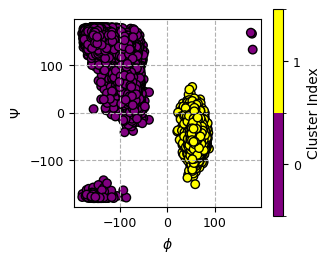

In [5]:
from matplotlib.colors import ListedColormap, BoundaryNorm

colors = ['purple', 'darkcyan', 'yellow']
cluster_boundaries = [0, 1, 2]  # You need one more boundary than the number of colors
cmap = ListedColormap(colors)
norm = BoundaryNorm(cluster_boundaries, cmap.N)

trajectory_ids = [0]*(len(trajData)//2) + [1]*(len(trajData)//2)

plt.figure(figsize=(3.37,2.8))
plt.xlabel("$\phi$")
plt.ylabel("$\Psi$")
plt.grid(axis='both', which='major', linestyle='--',)
im = plt.scatter(phi, psi, c=trajectory_ids, marker='.', cmap=cmap, norm=norm, edgecolor='k', s=150,rasterized=True)
plt.gca().set_aspect('equal')
cbar = plt.colorbar(im, ticks=np.arange(0.5, 3, 1))
cbar.set_ticklabels(np.arange(3))
cbar.set_label('Cluster Index')
plt.tight_layout()
plt.savefig(os.path.join(output_folder,"ala_phipsi_scatter_trajcolor.pdf"))
plt.savefig(os.path.join(output_folder,"ala_phipsi_scatter_trajcolor.png"))

## perform cluster scan 

In [6]:
cluster_array= np.arange(2,7,1).astype(int)
print("Scanning the following number of clusters",cluster_array)

Scanning the following number of clusters [2 3 4 5 6]


In [7]:
%%time
train_file = os.path.join(output_folder,'clusterscan_train.dat')
cv_file = os.path.join(output_folder,'clusterscan_cv.dat')

if os.path.exists(cv_file) and regenerate is False:
    train = np.loadtxt(train_file)
    cv = np.loadtxt(cv_file)
else:
    train, cv = cross_validate_component_scan(trajData, train_fraction=0.95, covar_type="kronecker", component_array = cluster_array, \
                                              n_training_sets=3, n_attempts = 8, \
                                              init_component_method = "kmeans++", dtype=torch.float64, device=device)
    np.savetxt(train_file, train)
    np.savetxt(cv_file, cv)

CPU times: user 1.19 ms, sys: 322 μs, total: 1.51 ms
Wall time: 2.26 ms


              3               4               3             33.2133          46.510
              3               4               4             33.2267          50.896
              3               4               5             33.3157          45.233
              3               4               6             33.2066          91.311
              3               4               7             33.0475          53.414
              3               4               8             33.3198          44.440
              3               5               1             33.4584          54.365
              3               5               2             33.5439          49.990
              3               5               3             33.7303          43.643
              3               5               4             33.4252          59.802
              3               5               5             33.7296          41.678
              3               5               6             33.3779         

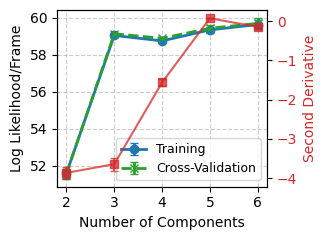

In [8]:
from shapeGMMTorch.utils import plot_log_likelihood_with_dd

# shapeGMMTorch plots has a built-in plot function for this type of plot
fig, ax = plt.subplots(1,1,figsize=(3.37,2.5), facecolor='w', edgecolor='k')
plot_log_likelihood_with_dd(ax, cluster_array, train, cv, fontsize=10, ylabel1=True, ylabel2=True, xlabel=True)
ax.legend(loc=0)
ax.set_ylabel("Log Likelihood/Frame")
plt.tight_layout()
plt.savefig(os.path.join(output_folder,"ala_clusterscan_ll_cv.pdf"))

## ShapeGMM fit with 3 clusters 

In [9]:
%%time

threestate_gmm_file = os.path.join(output_folder,'sgmm3.pickle')

if os.path.exists(threestate_gmm_file) and regenerate is False:
    with open(threestate_gmm_file, "rb") as f:
        sgmm3 = pickle.load(f)
else:
    sgmm3 = sgmm_fit_with_attempts(trajData, 3, 15, init_component_method='kmeans++', device=device, dtype=torch.float64)
    
    with open(threestate_gmm_file, 'wb') as fo:
        pickle.dump(sgmm3, fo)

CPU times: user 116 μs, sys: 1.7 ms, total: 1.82 ms
Wall time: 19 ms


## predict the labels and scores

In [10]:
cluster_ids_ = sgmm3.predict(trajData)
ll_pre_frame = sgmm3.score(trajData)

print(cluster_ids_.shape, ll_pre_frame)

(40002,) 34.2272465426602


## Make scatter plot on phi-psi colored with cluster ids

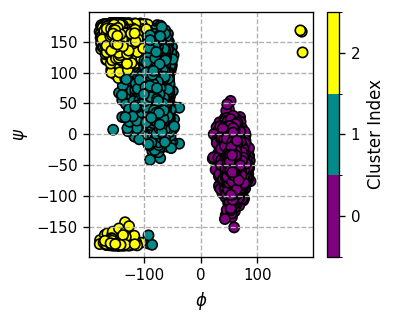

In [11]:
from matplotlib.colors import ListedColormap, BoundaryNorm

colors = ['purple', 'darkcyan', 'yellow']
cluster_boundaries = [0, 1, 2, 3]  # You need one more boundary than the number of colors
cmap = ListedColormap(colors)
norm = BoundaryNorm(cluster_boundaries, cmap.N)

plt.figure(figsize=(3.37,2.8), dpi=120)
plt.xlabel("$\phi$")
plt.ylabel("$\psi$")
plt.grid(axis='both', which='major', linestyle='--',)
im = plt.scatter(phi, psi, c=cluster_ids_, marker='.', cmap=cmap, norm=norm, 
                 edgecolor='k', s=150,rasterized=True)
cbar = plt.colorbar(im, ticks=np.arange(0.5, 3, 1))
cbar.set_ticklabels(np.arange(3))
cbar.set_label('Cluster Index')
plt.tight_layout()
plt.savefig(os.path.join(output_folder,"ala_threestate_phipsi_scatter_clustercolor.pdf"))

## perform global alignment of combined data 

In [12]:
print(trajData.shape)

(40002, 5, 3)


In [13]:
from shapeGMMTorch.align import maximum_likelihood_kronecker_alignment_frame_weighted as align

traj_tensor = torch.from_numpy(trajData).to(device)
weights = torch.ones(trajData.shape[0], device=device)

global_aligned_traj, global_avg, global_prec, lpdet = align(traj_tensor, weight_tensor=weights, max_iter=1000)
print(global_aligned_traj.shape)
print(global_avg.shape)
print(global_prec.shape)
print(lpdet)


torch.Size([40002, 5, 3])
torch.Size([5, 3])
torch.Size([5, 5])
tensor(-26.6449, device='cuda:0', dtype=torch.float64)


In [14]:
# convert to numpy array
global_aligned_traj = global_aligned_traj.cpu().numpy()
global_avg = global_avg.cpu().numpy()
global_prec = global_prec.cpu().numpy()

# save the data 
np.save(os.path.join(output_folder,'global_aligned_traj.npy'), global_aligned_traj, allow_pickle=True)
np.savetxt(os.path.join(output_folder,'global_avg.txt'), global_avg)
np.savetxt(os.path.join(output_folder,'global_prec.txt'), global_prec)

In [15]:
print(global_aligned_traj.shape)

(40002, 5, 3)


## extract frames from state 0 and 1 using globally aligned trajectory

In [16]:
c0_indx = np.argwhere(cluster_ids_==0)[:,0]
c1_indx = np.argwhere(cluster_ids_==1)[:,0]

print(len(c0_indx))
print(len(c1_indx))

20001
10835


In [17]:
c0_frames = global_aligned_traj[c0_indx]
c1_frames = global_aligned_traj[c1_indx]

combined_frames = np.concatenate([c0_frames, c1_frames], axis=0)
print(combined_frames.shape)

(30836, 5, 3)


In [18]:
labels = np.concatenate([cluster_ids_[c0_indx], cluster_ids_[c1_indx]], axis=0)
print(labels.shape)

(30836,)


## performing Linear Discriminant Analysis

In [19]:
# initialize
lda = WL.WeightedLDA()

# fit
lda.fit(combined_frames.reshape(-1, combined_frames.shape[1]*3), labels)

# tranform
ld1 = lda.transform(combined_frames.reshape(-1, combined_frames.shape[1]*3))[:,0]

In [20]:
print(ld1.shape, min(ld1), max(ld1))

(30836,) -21.49799205761828 11.4051202129903


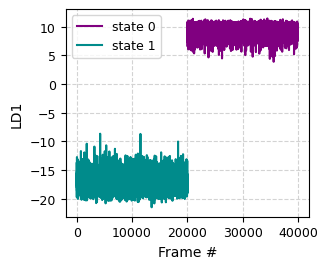

In [21]:
plt.figure(figsize=(3.37,2.8))
plt.grid(axis="both", which="major", linestyle="--", color="lightgrey")
plt.xlabel("Frame #")
plt.ylabel("LD1")

#NOTE, state 2 is intermixed

plt.plot(c0_indx, ld1[:len(c0_indx)], color='purple', lw=1.5, ls='-', label='state 0')
plt.plot(c1_indx, ld1[len(c0_indx):], color='darkcyan', lw=1.5, ls='-', label='state 1')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_folder,"frame_ld1_values.pdf"))

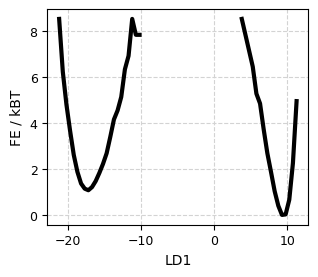

In [22]:
ld_range = [-25,15]
nbins = 80

# histogramming the lda and calculate free energy
hist, bins = np.histogram(ld1, range=ld_range, bins=nbins, density=True)

fe = -np.log(hist)
grids = (bins[:-1] + bins[1:])/2

plt.figure(figsize=(3.37,2.8))
plt.grid(axis="both", which="major", linestyle="--", color="lightgrey")
plt.xlabel("LD1")
plt.ylabel("FE / kBT")
plt.plot(grids, fe-fe.min(), 'k-', lw=3.0)

In [23]:
# save lda coefficients
print(lda.scalings_[:,0].shape)
np.savetxt(os.path.join(output_folder,"ld1_coeffs.txt"), lda.scalings_[:,0])

(15,)


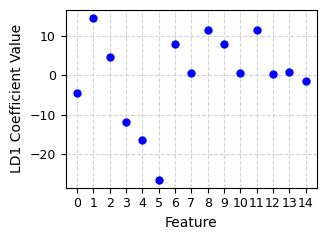

In [24]:
plt.figure(figsize=(3.37,2.5))
plt.ylabel('LD1 Coefficient Value')
plt.xlabel('Feature')
plt.grid(axis='both', which='major', linestyle='--', color='lightgrey')
plt.plot(np.arange(combined_frames.shape[1]*3), lda.scalings_[:,0], 'bo', lw=1.0, ms=5.0)
plt.xticks(np.arange(combined_frames.shape[1]*3))
plt.tight_layout()
plt.savefig(os.path.join(output_folder,"ld1_coefficients.pdf"))